# Purpose:
- Continued from 231021_signal_qc.ipynb
- Check each fluorescene traces (231105_signal_QC.pptx)
    - Determine to
        - correct
        - remove
        - or select frames (trials)

# How can I check if a weird pattern of signal is good or not?
- Look at the binned movie
- Also have a function to check specific chunk of frames


In [1]:
from pathlib import Path
from suite2p.io import BinaryFile
import h5py
import napari
import numpy as np
from matplotlib import pyplot as plt
from suite2p.gui import drawroi
import pandas as pd
base_dir = Path(r'E:\TPM\JK\h5')

In [2]:
mouse = 52
session_num = 13
plane = 1
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}' / f'{session_num:03}' / 'plane0'
# plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}' / 'test' / f'{session_num:03}' / 'plane0'

# data_fn = plane_dir / 'data.bin'
ops_fn = plane_dir / 'ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()
num_frames = ops['nframes']
num_frames


12019

In [3]:
# Plot F with finer x axis
import plotly.express as px
# remove_frames = np.arange(6550,6567)
remove_frames = []

roi_dir = plane_dir / 'roi'
F_fn = roi_dir / 'F_reduced.npy'
F = np.load(F_fn)
# fig, ax = plt.subplots(figsize=(15, 5))

show_frames = np.setdiff1d(np.arange(F.shape[1]), remove_frames)
F_show = F[:, show_frames]

px.line(np.mean(F_show, 0), title=f'JK{mouse:03} session {session_num:03} plane {plane} F', labels={'x':'frame', 'y':'F'})
# ax.set_xticks(np.arange(0, num_frames, 200))
# ax.set_title(f'JK{mouse:03} session {session_num:03} plane {plane} F')
# ax.tick_params(axis='x', rotation=45)
# ax.set_xlim([0, 300])


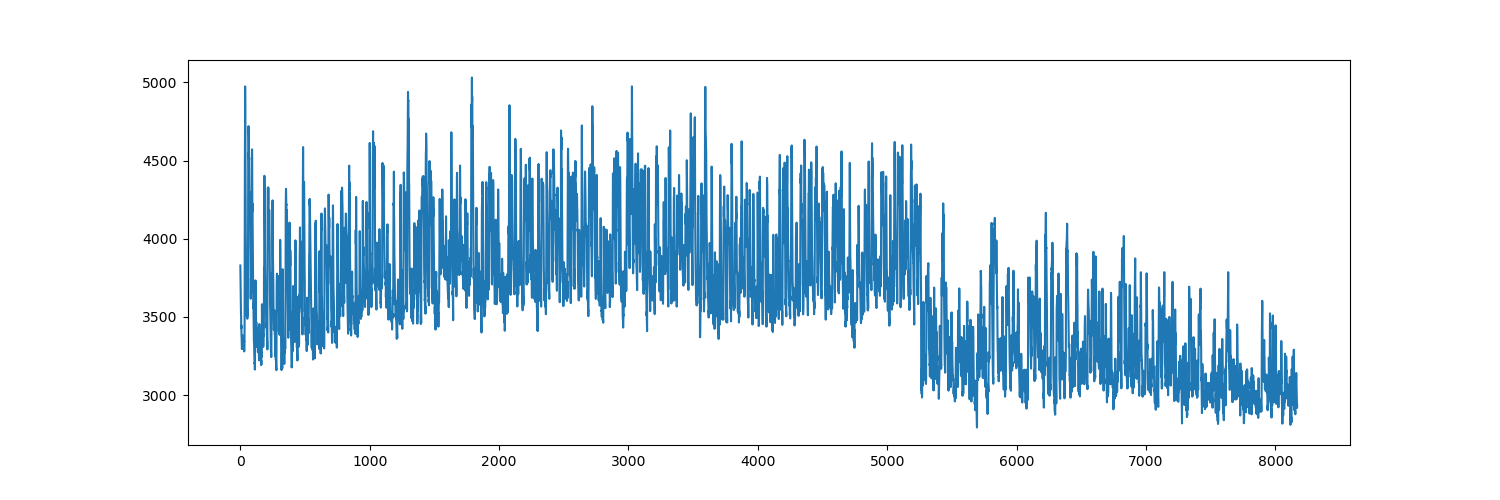

In [6]:
remove_frame_inds = np.arange(5263, 8769)
F = F[:, np.setdiff1d(np.arange(F.shape[1]), remove_frame_inds)]
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(np.mean(F, 0))

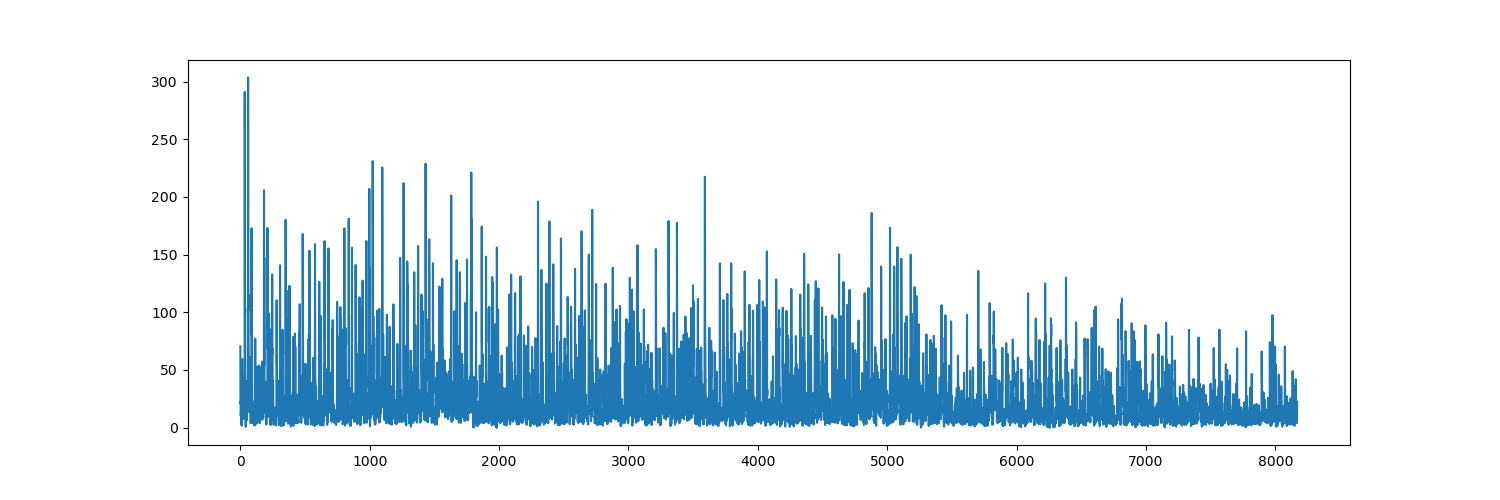

In [7]:
spks_fn = roi_dir / 'spks_reduced.npy'
spks = np.load(spks_fn)
spks = spks[:, np.setdiff1d(np.arange(spks.shape[1]), remove_frame_inds)]
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(np.mean(spks, 0))

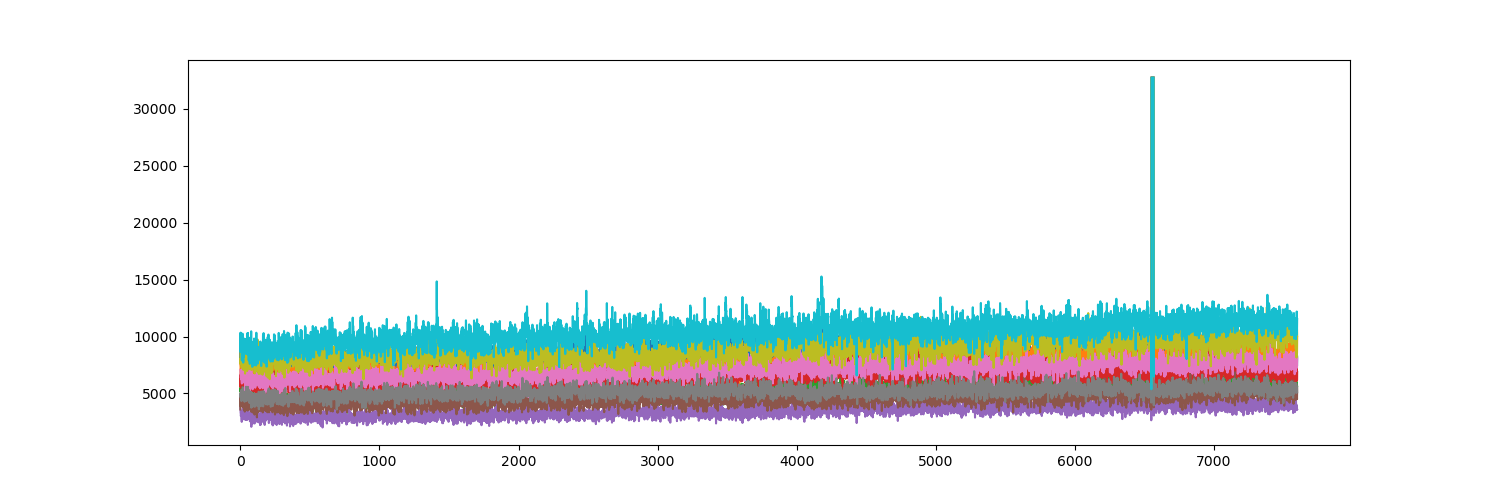

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
for i in range(10):
    ax.plot(F[i])

In [6]:
bin_size = 20
interval = 600
start_ind = 0
num_bins = (num_frames - start_ind) // (bin_size + interval)
start_inds = np.arange(num_bins) * (bin_size + interval) + start_ind
binned_movie = np.zeros((num_bins, ops['Ly'], ops['Lx']), dtype=np.float32)
with BinaryFile(Ly=ops['Ly'], Lx=ops['Lx'], read_filename=data_fn) as f:
    i = 0
    for i in range(num_bins):
        f._index = start_inds[i]
    
        binned_movie[i] = np.mean(f.read(bin_size)[1],0)
    

In [41]:
start_inds

array([   0,  650, 1300, 1950, 2600, 3250, 3900, 4550, 5200, 5850, 6500,
       7150, 7800, 8450])

In [7]:
viewer = napari.Viewer()
viewer.add_image(binned_movie, colormap='gray', name=f'{mouse:03}_S{session_num:03}_plane{plane}')

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer '039_S018_plane1' at 0x1e23620cc70>

In [25]:
# Part of the movie
start_ind = 6400
duration = 200
part_movie = np.zeros((duration, ops['Ly'], ops['Lx']), dtype=np.float32)
with BinaryFile(Ly=ops['Ly'], Lx=ops['Lx'], read_filename=data_fn) as f:
    for i in range(duration):
        f._index = start_ind + i
        part_movie[i] = f.read()[1]

In [13]:
binning = 20
binned_part_movie = np.zeros((duration//binning, ops['Ly'], ops['Lx']), dtype=np.float32)
for i in range(duration//binning):
    binned_part_movie[i] = np.mean(part_movie[i*binning:(i+1)*binning], 0)

In [26]:
viewer = napari.Viewer()
viewer.add_image(part_movie, colormap='gray', name=f'{mouse:03}_S{session_num:03}_plane{plane}')
# viewer.add_image(binned_part_movie, colormap='gray', name=f'{mouse:03}_S{session_num:03}_plane{plane}')

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer '052_S014_plane7' at 0x20a92e64a60>

Text(0.5, 1.0, 'JK039 plane 3 session 11 spks')

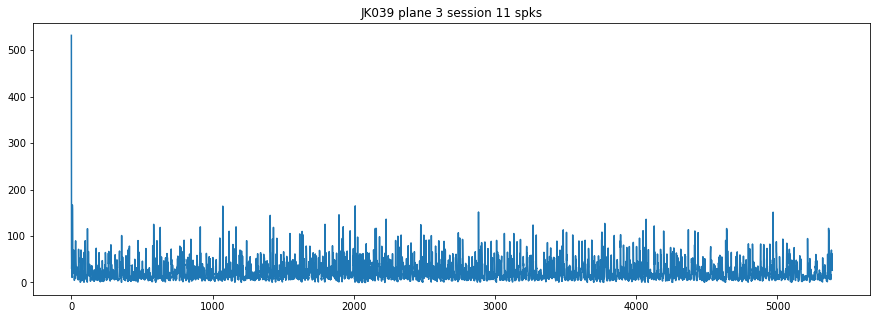

In [74]:
roi_dir = plane_dir / 'roi'
spks_fn = roi_dir / 'spks_reduced.npy'
spks = np.load(spks_fn)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(np.mean(spks, 0))
ax.set_title(f'JK{mouse:03} plane {plane} session {session_num} spks')

In [12]:
np.unique(spks)

array([0.0000000e+00, 3.2739685e-04, 4.2397034e-04, ..., 6.4133130e+03,
       8.6975000e+03, 8.9729189e+03], dtype=float32)

## Read from the h5 file
- Before registration

In [52]:
h5_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
h5_fn = h5_dir / f'{mouse:03}_{session_num:03}_000_plane_{plane}.h5'
start_ind = 1200
with h5py.File(h5_fn, 'r') as h:
    part_movie_h5 = h['data'][start_ind:start_ind+duration]

In [53]:
viewer = napari.Viewer()
viewer.add_image(part_movie_h5, colormap='gray', name=f'{mouse:03}_S{session_num:03}_plane{plane}')

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer '036_S010_plane5' at 0x22d46879fa0>

# Re-calculating signals

In [78]:
def save_signal(mouse, plane, session, base_dir):
    
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    session_dir = plane_dir / f'{session}/plane0'
    roi_dir = session_dir / 'roi'
    final_mask_fn = roi_dir / 'final_mask.npy'
    final_mask = np.load(final_mask_fn)
    ops_fn = session_dir / 'ops.npy'
    ops = np.load(ops_fn, allow_pickle=True).item()
    ops['reg_file'] = session_dir / 'data.bin'

    # Get signals from the mask
    numROI = final_mask.shape[2]
    statBlank = []
    stat0 = []
    for ci in range(numROI):
        roi_mask = final_mask[:,:,ci]
        (ypix, xpix) = np.unravel_index(np.where(roi_mask.flatten())[0], roi_mask.shape)
        lam = np.ones(ypix.shape)/len(ypix)
        med = (np.median(ypix), np.median(xpix))
        stat0.append({'ypix': ypix, 'xpix': xpix, 'lam': lam, 'npix': ypix.size, 'med': med})
    F, Fneu, _, _, spks, ops, stat = drawroi.masks_and_traces(ops, stat0, statBlank)
    iscell = np.ones((numROI,2), 'uint8')

    # Get frame time to remove first and last frame of each trial
    # to remove negative ticks from laser blocking
    frame_time_fn = plane_dir / f'{mouse:03}_{session}_plane_{plane}_frame_time.pkl'
    frame_time = pd.read_pickle(frame_time_fn)
    reduced_frame_time = frame_time.groupby('trialNum').apply(lambda x: x.iloc[1:-1]).reset_index(drop=True)
    reduced_frame_indice = reduced_frame_time.frame_index.values.astype(int)

    F_reduced = F[:,reduced_frame_indice]
    Fneu_reduced = Fneu[:,reduced_frame_indice]
    spks_reduced = spks[:,reduced_frame_indice]

    # Save the results
    F_fn = roi_dir / 'F_reduced.npy'
    Fneu_fn = roi_dir / 'Fneu_reduced.npy'
    spks_fn = roi_dir / 'spks_reduced.npy'
    reduced_frame_time_fn = roi_dir / 'reduced_frame_time.pkl'
    ops_fn = roi_dir / 'ops.npy'
    stat_fn = roi_dir / 'stat.npy'
    iscell_fn = roi_dir / 'iscell.npy'
    np.save(F_fn, F_reduced)
    np.save(Fneu_fn, Fneu_reduced)
    np.save(spks_fn, spks_reduced)
    reduced_frame_time.to_pickle(reduced_frame_time_fn)
    np.save(ops_fn, ops)
    np.save(stat_fn, stat)
    np.save(iscell_fn, iscell)

In [79]:
mouse = 39
planes = np.arange(1,9)
session = '011'
for plane in planes:
    save_signal(mouse, plane, session, base_dir)

Masks made in 2.13 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numba\core\ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_ipix' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\..\Anaconda3\envs\suite2p\lib\site-packages\suite2p\extraction\extract.py", line 105:
@njit(parallel=True)
def matmul_traces(Fi, data, cell_ipix, cell_lam):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numba\core\ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_lam' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference

Extracted fluorescence from 216 ROIs in 5835 frames, 33.87 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 2.50 sec.
Extracted fluorescence from 239 ROIs in 5835 frames, 21.80 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 2.43 sec.
Extracted fluorescence from 277 ROIs in 5835 frames, 21.75 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 2.90 sec.
Extracted fluorescence from 286 ROIs in 5835 frames, 20.87 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 2.42 sec.
Extracted fluorescence from 271 ROIs in 5883 frames, 22.75 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 2.29 sec.
Extracted fluorescence from 230 ROIs in 5883 frames, 19.89 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 3.01 sec.
Extracted fluorescence from 306 ROIs in 5883 frames, 22.50 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 3.65 sec.
Extracted fluorescence from 326 ROIs in 5883 frames, 21.98 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


# Record frames to remove
- Later change it to trials, from the pkl file

# Create dataframe for processed sessions and planes
- Add columns for removal
- Only for 6 expert mice

In [8]:
base_dir

WindowsPath('E:/TPM/JK/h5')

In [9]:
mice = [25,27,30,36,39,52]
planes = range(1,9)
session_tuples = []
for mouse in mice:
    for plane in planes:
        plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
        sessions = [x.name for x in plane_dir.iterdir() if x.is_dir() and x.name[0].isdigit() and x.name[-1].isdigit()]
        # list of (mouse,plane,session) tuples
        test_sessions = [(mouse, plane, session) for session in sessions]
        session_tuples.extend(test_sessions)

In [12]:
expert_mice_data_struct = {'mouse': [st[0] for st in session_tuples],
                           'plane': [st[1] for st in session_tuples],
                           'session': [st[2] for st in session_tuples]}
expert_mice_df = pd.DataFrame(expert_mice_data_struct)
expert_mice_df

,mouse,plane,session
0,25,1,001
1,25,1,002
2,25,1,003
3,25,1,004
4,25,1,005
...,...,...,...
1467,52,8,5554_2
1468,52,8,5554_3
1469,52,8,5554_4
1470,52,8,9998_1


## Add anomalies
- Session types: training, ref, piezo, Spontaneous, pre
- session-to-session matching (depth matching)
- file processing error (e.g., JK039 S18)
- signal issue
- frames_to_remove for photobleaching (JK039 & 052)

In [40]:
session_type = []
mice =          [25,    27,   30,   36,     39,     52]
ref_sessions =   [4,     3,    3,    1,      1,      3]
exp_sessions =   [[19],    [8,9,10,12,13,16],   [21],   [17],     [22,23],     [21,22,23,25]]
no_whisker_sessions = [[23,24,25], [23,24,25], [23,24,25], [19,20,21], [26,27,28], []]
radial_sessions = [[22], [14,17], [22], [18], [24,25], [4,26]]
for i in range(len(expert_mice_df)):
    session = expert_mice_df.session[i]
    mouse = expert_mice_df.mouse[i]
    if len(session) > 3: # either piezo or spont
        if session[0] == '5':
            session_type.append('spont')
        elif session[0] == '9':
            session_type.append('piezo')
        else:
            raise ValueError('Session name must start with 5 or 9 when longer than 3 characters')
    elif session[0] == '9':
        session_type.append('pre')
    else:
        mi = mice.index(mouse)
        if int(session) == ref_sessions[mi]:
            session_type.append('test_naive')
        elif int(session) in exp_sessions[mi]:
            session_type.append('test_expert')
        elif int(session) in no_whisker_sessions[mi]:
            session_type.append('no_whisker')
        elif int(session) in radial_sessions[mi]:
            session_type.append('radial')
        else:
            session_type.append('training')


        

In [41]:
expert_mice_df['session_type'] = session_type
expert_mice_df.to_csv(base_dir / 'expert_mice.csv')

In [44]:
df_test = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
df_test

,mouse,plane,session,session_type
0,25,1,001,training
1,25,1,002,training
2,25,1,003,training
3,25,1,004,test_naive
4,25,1,005,training
...,...,...,...,...
1467,52,8,5554_2,spont
1468,52,8,5554_3,spont
1469,52,8,5554_4,spont
1470,52,8,9998_1,piezo


In [81]:
# adding session-to-session reg
expert_mice_df['depth_matched'] = False


In [82]:
for mouse in mice:
    for plane in planes:
        sts_reg_fn = base_dir / f'{mouse:03}/plane_{plane}/JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
        sts_reg = np.load(sts_reg_fn, allow_pickle=True).item()
        matched_session_nums = sts_reg['selected_session_num']
        matched_row_inds = np.intersect1d(np.intersect1d(np.where(expert_mice_df.mouse==mouse)[0],
                                                         np.where(expert_mice_df.plane==plane)[0]),
                                          np.where([sn in matched_session_nums for sn in expert_mice_df.session.astype(int)])[0])
                
        expert_mice_df.loc[matched_row_inds, 'depth_matched'] = True

In [84]:
expert_mice_df.to_csv(base_dir / 'expert_mice.csv')

In [98]:
# add file processing error
# manual addition + automatic addition
# automatic addition from 'roi' folder (spks_reduced.npy)
# manual addition from 231105_signa_QC.pptx

# Adding JK030 session 08 due to mirror movement 2023/12/09
# See behavior note
expert_mice_df['file_processing_error'] = False
manual_error_tuple = [(30, 1, '023'), (30, 2, '023'), (30, 3, '023'), (30, 4, '023'), (30, 5, '023'), (30, 6, '023'), (30, 7, '023'), (30, 8, '023'),
                      (36, 1, '011'), (36, 2, '011'), (36, 3, '011'), (36, 4, '011'), (36, 5, '011'), (36, 6, '011'), (36, 7, '011'), (36, 8, '011'),
                      (36, 1, '008'), (36, 2, '008'), (36, 3, '008'), (36, 4, '008'), (36, 5, '008'), (36, 6, '008'), (36, 7, '008'), (36, 8, '008'),
                      ]
auto_error_tuple = []
for i, row in expert_mice_df.iterrows():
    mouse = row.mouse
    plane = row.plane
    session = row.session
    roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/roi'
    spks_fn = roi_dir / 'spks_reduced.npy'
    if not spks_fn.exists():
        auto_error_tuple.append((mouse, plane, session))


In [103]:
error_tuple = manual_error_tuple + auto_error_tuple
processing_error = [False] * len(expert_mice_df)
for i, row in expert_mice_df.iterrows():
    mouse = row.mouse
    plane = row.plane
    session = row.session
    if (mouse, plane, session) in error_tuple:
        processing_error[i] = True
expert_mice_df['processing_error'] = processing_error

In [106]:
# remove column called 'file_processing_error' from expert_mice_df
expert_mice_df = expert_mice_df.drop(columns=['file_processing_error'])

In [ ]:
expert_mice_df.to_csv(base_dir / 'expert_mice.csv')

In [294]:
expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)

In [295]:
expert_mice_df.drop(columns=['remove_frame_ind'], inplace=True)
expert_mice_df

,mouse,plane,session,session_type,depth_matched,processing_error
0,25,1,001,training,True,False
1,25,1,002,training,True,False
2,25,1,003,training,True,False
3,25,1,004,test_naive,True,False
4,25,1,005,training,True,False
...,...,...,...,...,...,...
1467,52,8,5554_2,spont,False,True
1468,52,8,5554_3,spont,False,True
1469,52,8,5554_4,spont,False,True
1470,52,8,9998_1,piezo,False,True


In [314]:
import re
delimiters = ["[", ",", "]", " "]

# Create a regex pattern that matches any of the delimiters
delimiter_pattern = '|'.join(re.escape(d) for d in delimiters)

remove_frames_df = pd.read_csv(base_dir / 'manual_frame_removal.csv')

remove_frames_df['session'] = remove_frames_df['session'].apply(lambda x: f'{x:03}')
remove_frames_df['remove_frame_ind'] = remove_frames_df.remove_frame_ind.apply(lambda x: np.array([int(y) for y in re.split(delimiter_pattern, x) if y.isnumeric()]))
remove_frames_df[:10]

,mouse,session,plane,remove_frame_ind
0,27,004,1,"[5263, 8768]"
1,27,004,2,"[5263, 8768]"
2,27,004,3,"[5263, 8768]"
3,27,004,4,"[5263, 8768]"
4,27,004,5,"[5102, 7316]"
5,27,004,6,"[5102, 7316]"
6,27,004,7,"[5102, 7316]"
7,27,004,8,"[5102, 7316]"
8,27,015,5,"[3142, 3226, 3776, 3825]"
9,27,015,6,"[3142, 3226, 3776, 3825]"


In [315]:
remove_frames_df.remove_frame_ind.values[0]

array([5263, 8768])

In [317]:
if 'remove_frame_ind' in expert_mice_df.columns:
    expert_mice_df.drop(columns=['remove_frame_ind'], inplace=True)
expert_mice_df

,mouse,plane,session,session_type,depth_matched,processing_error
0,25,1,001,training,True,False
1,25,1,002,training,True,False
2,25,1,003,training,True,False
3,25,1,004,test_naive,True,False
4,25,1,005,training,True,False
...,...,...,...,...,...,...
1467,52,8,5554_2,spont,False,True
1468,52,8,5554_3,spont,False,True
1469,52,8,5554_4,spont,False,True
1470,52,8,9998_1,piezo,False,True


In [323]:
new_expert_mice_df = pd.merge(expert_mice_df, remove_frames_df, on=['mouse', 'plane', 'session'], how='left')
new_expert_mice_df.fillna(0, inplace=True)
new_expert_mice_df


,mouse,plane,session,session_type,depth_matched,processing_error,remove_frame_ind
0,25,1,001,training,True,False,0
1,25,1,002,training,True,False,0
2,25,1,003,training,True,False,0
3,25,1,004,test_naive,True,False,0
4,25,1,005,training,True,False,0
...,...,...,...,...,...,...,...
1467,52,8,5554_2,spont,False,True,0
1468,52,8,5554_3,spont,False,True,0
1469,52,8,5554_4,spont,False,True,0
1470,52,8,9998_1,piezo,False,True,0


In [319]:
np.where(new_expert_mice_df.remove_frame_ind.isna())

(array([], dtype=int64),)

In [320]:
np.where(new_expert_mice_df.remove_frame_ind.values != 0)[0]

C:\Users\shires\AppData\Local\Temp/ipykernel_22876/583262848.py:1: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



array([0], dtype=int64)

In [321]:
new_expert_mice_df.remove_frame_ind.unique()

TypeError: unhashable type: 'numpy.ndarray'

In [283]:
expert_mice_df.session.unique()

array(['001', '002', '003', '004', '005', '006', '013', '014', '015',
       '016', '017', '018', '019', '022', '023', '024', '025', '5555_001',
       '5555_002', '5555_003', '5555_004', '5555_012', '5555_013',
       '5555_014', '5555_103', '9999_1', '9999_2', '007', '008', '009',
       '010', '011', '012', '5554_001', '5554_002', '5554_003',
       '5554_004', '5554_012', '5554_013', '5554_014', '5554_103',
       '9998_1', '9998_2', '5555_104', '5554_104', '020', '021', '901',
       '902', '5555_010', '5555_011', '5555_101', '5555_110', '5555_111',
       '5554_010', '5554_011', '5554_101', '5554_110', '5554_111', '026',
       '027', '028', '5555_100', '5554_100', '029', '5555_1', '5555_2',
       '5555_3', '5555_4', '5554_1', '5554_2', '5554_3', '5554_4'],
      dtype=object)

In [ ]:
new_expert_mice_df.to_csv(base_dir / 'expert_mice.csv')

In [332]:
new_expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv')

In [333]:
new_expert_mice_df

,Unnamed: 0,mouse,plane,session,session_type,depth_matched,processing_error,remove_frame_ind
0,0,25,1,001,training,True,False,0
1,1,25,1,002,training,True,False,0
2,2,25,1,003,training,True,False,0
3,3,25,1,004,test_naive,True,False,0
4,4,25,1,005,training,True,False,0
...,...,...,...,...,...,...,...,...
1467,1467,52,8,5554_2,spont,False,True,0
1468,1468,52,8,5554_3,spont,False,True,0
1469,1469,52,8,5554_4,spont,False,True,0
1470,1470,52,8,9998_1,piezo,False,True,0


In [334]:
# remove redundant sessions and bubble issue sessions from JK052
# session names 019, 022, 023, 024, 025, 026, 027, 028, 029
jk052_remove_sessions = ['019', '022', '023', '024', '025', '026', '027', '028', '029']
remove_ind = np.where((new_expert_mice_df.mouse==52) & (new_expert_mice_df.session.isin(jk052_remove_sessions)))[0]
new_expert_mice_df.drop(index=remove_ind, inplace=True)

In [336]:
new_expert_mice_df.query('mouse==52 and plane==5')

,Unnamed: 0,mouse,plane,session,session_type,depth_matched,processing_error,remove_frame_ind
1340,1340,52,5,001,training,True,False,[ 0 32]
1341,1341,52,5,003,test_naive,True,False,[ 0 186]
1342,1342,52,5,004,radial,True,False,[ 0 89]
1343,1343,52,5,006,training,True,False,0
1344,1344,52,5,007,training,True,False,[ 0 142]
1345,1345,52,5,008,training,True,False,[ 0 160]
1346,1346,52,5,009,training,True,False,[ 0 210]
1347,1347,52,5,010,training,True,False,[ 0 133]
1348,1348,52,5,011,training,True,False,[ 0 142]
1349,1349,52,5,012,training,True,False,[ 0 236]


In [338]:
new_expert_mice_df.to_csv(base_dir / 'expert_mice.csv')

# Now apply these remove_frame_ind
- Check the final signal again
- Follow-up in 231209_manual_trial_removal.ipynb